In [276]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [291]:
class GModReLUFunction(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.

    Hyperbolic kernel
    f(x) = \frac{\lambda}{1 - x/k\lambda}

    Forward:
    y = R(x) = max(0,x)

    Backwards:
    \frac{\del J}{\del X} \approx 
    """

    @staticmethod
    def forward(ctx, input,l,k):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        ctx.l = l 
        ctx.k = k
        return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        l, k = ctx.l, ctx.k
        if l == 0 or k == 0:
            grad_input = (input > 0).float() * grad_output
        else:
            # Standard ReLU mask
            positive_mask = (input > 0).float()
            kernel = l/ (1 + torch.abs(input*grad_output)/(l*k))
            grad_input = torch.where(
                grad_output > 0,
                positive_mask,
                positive_mask - torch.sign(input)*kernel)*grad_output
        return grad_input, None, None

class GModReLU(nn.Module):
    def __init__(self, l = 0.1,k = 5.5):
        """
        negative_grad_scale: float, how much gradient to inject in dead regions
        mode: 'positive_only' or 'full'
        """
        super().__init__()
        self.l = l
        self.k = k

    def forward(self, input):
        return GModReLUFunction.apply(input, self.l, self.k)

In [44]:
dtype = torch.float
device = torch.device("cpu")


In [243]:
# a = np.concatenate((np.exp(np.linspace(-3,10,9)),np.linspace(0,10,2)),0)
# a = np.concatenate((-np.exp(np.linspace(7,-2,8)),np.linspace(0,10,2)),0)
a = np.concatenate((-np.exp(np.linspace(4,-2,9)),np.linspace(0,10,2)),0)
d = []

for i in range(a.shape[0]):
    x = torch.linspace(-10, 10, 800, device=device, dtype=dtype, requires_grad=True)
    GMReLu = GMReLuFunction.apply
    y = GMReLu(x,0.3,5.5)
    grad_out_val = a[i]
    loss = grad_out_val*y.sum()
    loss.backward()
    d.append(x.grad)

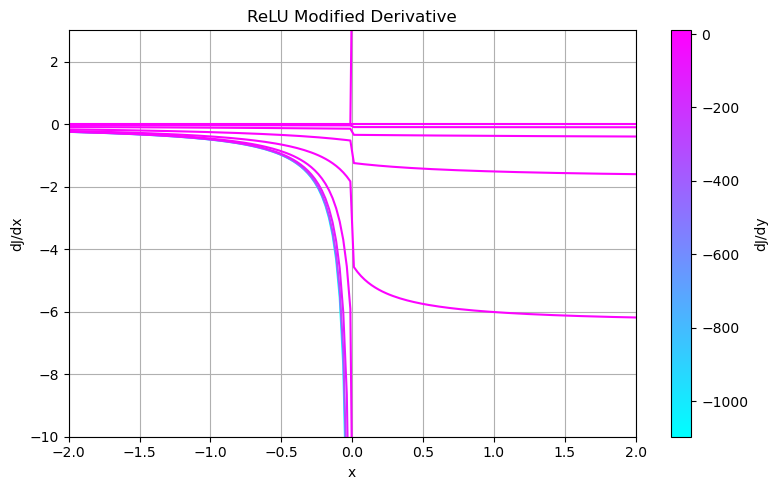

In [241]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Assuming x, a, and d are already NumPy arrays
x_np = x.detach().cpu().numpy()
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=a.min(), vmax=a.max())
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
colors = smap.to_rgba(a)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the curves
for i, y in enumerate(d):
    ax.plot(x_np, y, color=colors[i])

# Axis labels and title
ax.set_xlabel("x")
ax.set_ylabel("dJ/dx")
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 3)
ax.set_title("ReLU Modified Derivative")
ax.grid(True)

# Add colorbar on the right
cbar = fig.colorbar(smap, ax=ax, orientation='vertical', label='dJ/dy')

plt.tight_layout()
plt.savefig('modified_relu.png')
plt.show()


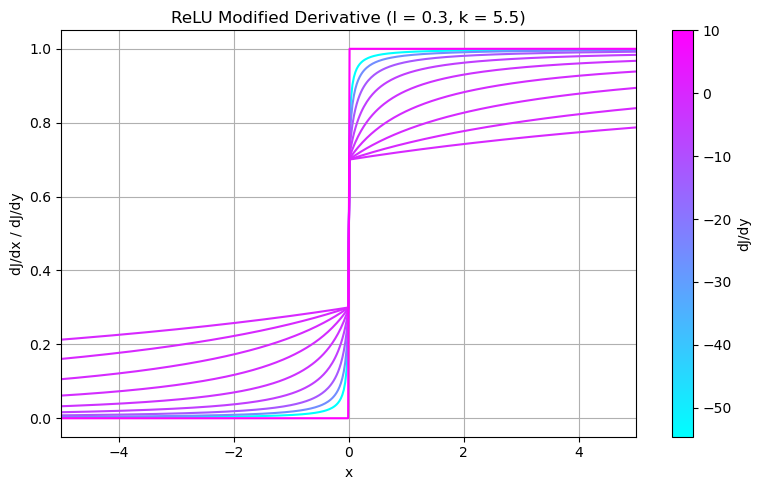

In [247]:
x_np = x.detach().cpu().numpy()
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=a.min(), vmax=a.max())
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
colors = smap.to_rgba(a)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the curves
for i, y in enumerate(d):
    ax.plot(x_np, y/a[i], color=colors[i])

# Axis labels and title
ax.set_xlabel("x")
ax.set_ylabel("dJ/dx / dJ/dy")
ax.set_xlim(-5, 5)
ax.set_title("ReLU Modified Derivative (l = 0.3, k = 5.5)")
ax.grid(True)

# Add colorbar on the right
fig, ax = plt.subplots(figsize=(8, 5))
cbar = fig.colorbar(smap, ax=ax, orientation='vertical', label='dJ/dy')

plt.tight_layout()
plt.show()

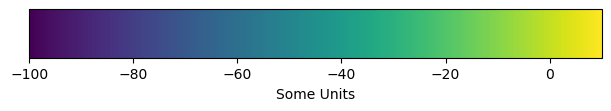

In [112]:


cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=-100, vmax=10)
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)



In [334]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download KMNIST
# full_train = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
# CIFAR 10
full_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:39<00:00, 4268358.76it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [335]:
from torch.utils.data import random_split

# Split into train and val
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

TypeError: Invalid shape (3, 32, 32) for image data

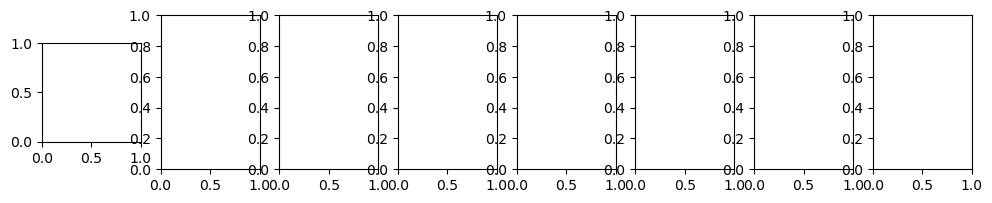

In [338]:

# Visualize some examples
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i])
    axes[i].axis('off')
plt.suptitle('Sample KMNIST Images')
plt.show()

In [348]:
images.shape

torch.Size([64, 3, 32, 32])

In [352]:
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super().__init__()
        self.activation = activation_fn

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [447]:
lr = 0.001
model = CNN(GModReLU(0.02,0.0003)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model.train()
images, labels = next(iter(train_loader))
optimizer.zero_grad()
outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()


In [890]:
from collections import defaultdict, deque
from tqdm import tqdm
import numpy as np

def train_and_evaluate(activation, train_loader, val_loader, epochs=10, lr=0.001, log_every=100, device='cpu', logger = None):
    model = CNN(activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    logs = defaultdict(list)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        grad_norms = []
        weight_updates = []
        
        running_loss = deque(maxlen=50)  # For smooth display
        running_acc = deque(maxlen=50)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradients and updates
            total_norm = 0
            weight_update_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
                    weight_update_norm += (lr * p.grad.data).norm(2).item() ** 2

            grad_norms.append(np.sqrt(total_norm))
            weight_updates.append(np.sqrt(weight_update_norm))

            optimizer.step()

            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size
            total += batch_size

            batch_acc = (outputs.argmax(1) == labels).float().mean().item()
            correct += (outputs.argmax(1) == labels).sum().item()

            if batch_idx % log_every == 0:
                logs['batches'].append({
                    'epoch': epoch,
                    'batch_idx': batch_idx,
                    'loss': loss.item(),
                    'acc': batch_acc,
                    'grad_norm': grad_norms[-1],
                    'weight_update_norm': weight_updates[-1],
                    'samples_seen': total
                })


            # Track running stats for display
            running_loss.append(loss.item())
            running_acc.append(batch_acc)

            if batch_idx % 10 == 0:
                pbar.set_postfix({
                    'loss': f'{np.mean(running_loss):.4f}',
                    'acc': f'{np.mean(running_acc) * 100:.2f}%',
                    'grad_norm': f'{grad_norms[-1]:.2f}'
                })

        logs['train_loss'].append(total_loss / total)
        logs['train_acc'].append(correct / total)
        logs['train_grad_norm'].append(np.mean(grad_norms))
        logs['train_weight_update_norm'].append(np.mean(weight_updates))

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += inputs.size(0)

        logs['val_loss'].append(val_loss / val_total)
        logs['val_acc'].append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {logs['train_loss'][-1]:.4f} | "
              f"Train Acc: {logs['train_acc'][-1]*100:.2f}% | "
              f"Val Acc: {logs['val_acc'][-1]*100:.2f}%")

    if logger != None:
        logger(("gmodrelu",l,k),logs)
        
    return logs

In [659]:
for i in range(3):
    logs_gelu = train_and_evaluate(
        torch.nn.GELU(),
        k=0.0,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=10,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    insert_log_data(("gelu"),logs_gelu)

Epoch 1/10 | Train Loss: 1.4315 | Train Acc: 48.09% | Val Acc: 58.48%


Epoch 2/10 | Train Loss: 0.9991 | Train Acc: 64.52% | Val Acc: 67.58%


Epoch 3/10 | Train Loss: 0.8016 | Train Acc: 71.82% | Val Acc: 69.96%


Epoch 4/10 | Train Loss: 0.6781 | Train Acc: 76.22% | Val Acc: 72.98%


Epoch 5/10 | Train Loss: 0.5811 | Train Acc: 79.84% | Val Acc: 71.46%


Epoch 6/10 | Train Loss: 0.4947 | Train Acc: 82.55% | Val Acc: 74.72%


Epoch 7/10 | Train Loss: 0.4207 | Train Acc: 85.19% | Val Acc: 75.00%


Epoch 8/10 | Train Loss: 0.3570 | Train Acc: 87.40% | Val Acc: 73.90%


Epoch 9/10 | Train Loss: 0.2978 | Train Acc: 89.49% | Val Acc: 74.48%


Epoch 10/10 | Train Loss: 0.2402 | Train Acc: 91.42% | Val Acc: 73.00%


Epoch 1/10 | Train Loss: 1.4394 | Train Acc: 47.87% | Val Acc: 56.54%


Epoch 2/10 | Train Loss: 1.0150 | Train Acc: 64.01% | Val Acc: 67.72%


Epoch 3/10 | Train Loss: 0.8175 | Train Acc: 71.26% | Val Acc: 71.70%


Epoch 4/10 | Train Loss: 0.6927 | Train Acc: 75.72% | Val Acc: 72.62%


Epoch 5/10 | Train Loss: 0.5966 | Train Acc: 78.98% | Val Acc: 73.40%


Epoch 6/10 | Train Loss: 0.5089 | Train Acc: 82.16% | Val Acc: 74.92%


Epoch 7/10 | Train Loss: 0.4323 | Train Acc: 84.58% | Val Acc: 74.64%


Epoch 8/10 | Train Loss: 0.3600 | Train Acc: 87.36% | Val Acc: 74.40%


Epoch 9/10 | Train Loss: 0.2933 | Train Acc: 89.58% | Val Acc: 73.40%


Epoch 10/10 | Train Loss: 0.2422 | Train Acc: 91.31% | Val Acc: 74.50%


Epoch 1/10 | Train Loss: 1.4473 | Train Acc: 46.93% | Val Acc: 56.72%


Epoch 2/10 | Train Loss: 1.0187 | Train Acc: 63.90% | Val Acc: 65.50%


Epoch 3/10 | Train Loss: 0.8346 | Train Acc: 70.50% | Val Acc: 69.90%


Epoch 4/10 | Train Loss: 0.7154 | Train Acc: 74.85% | Val Acc: 71.02%


Epoch 5/10 | Train Loss: 0.6214 | Train Acc: 78.09% | Val Acc: 73.14%


Epoch 6/10 | Train Loss: 0.5370 | Train Acc: 80.98% | Val Acc: 72.70%


Epoch 7/10 | Train Loss: 0.4622 | Train Acc: 83.65% | Val Acc: 74.54%


Epoch 8/10 | Train Loss: 0.3998 | Train Acc: 85.71% | Val Acc: 74.90%


Epoch 9/10 | Train Loss: 0.3412 | Train Acc: 87.90% | Val Acc: 75.30%


Epoch 10/10 | Train Loss: 0.2836 | Train Acc: 89.98% | Val Acc: 74.02%


In [441]:
log_data = dict()
def insert_log_data(key,data):
    if key not in log_data:
        log_data[key] = []
    log_data[key].append(data)

In [948]:
logs_gmodrelus = [] 
k_vals = np.exp(np.linspace(math.log(1.e-06),math.log(5.e-03),8))
for i in range(k_vals.shape[0]):
    log = train_and_evaluate(
        GModReLU(l=0.02,k=k_vals[i]),
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=10,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    insert_log_data(("gmodrelu",0.02,k_vals[i]),log)
    logs_gmodrelus.append(log)

Epoch 1/10 | Train Loss: 1.4126 | Train Acc: 48.74% | Val Acc: 59.56%


Epoch 2/10 | Train Loss: 0.9735 | Train Acc: 65.65% | Val Acc: 67.96%


Epoch 3/10 | Train Loss: 0.7902 | Train Acc: 72.52% | Val Acc: 71.22%


Epoch 4/10 | Train Loss: 0.6609 | Train Acc: 77.01% | Val Acc: 73.64%


Epoch 5/10 | Train Loss: 0.5599 | Train Acc: 80.42% | Val Acc: 73.86%


Epoch 6/10 | Train Loss: 0.4673 | Train Acc: 83.71% | Val Acc: 74.58%


Epoch 7/10 | Train Loss: 0.3863 | Train Acc: 86.35% | Val Acc: 76.04%


Epoch 8/10 | Train Loss: 0.3107 | Train Acc: 88.94% | Val Acc: 75.18%


Epoch 9/10 | Train Loss: 0.2417 | Train Acc: 91.36% | Val Acc: 75.54%


Epoch 10/10 | Train Loss: 0.1942 | Train Acc: 93.08% | Val Acc: 75.32%


KeyboardInterrupt: 

In [473]:
for i in range(k_vals.shape[0]):
    insert_log_data(("gmodrelu",0.02,k_vals[i]),logs_gmodrelus[i])

In [301]:
def extract_batch_metric(logs, metric_name):
    """
    Extracts a specific batch-level metric from logs['batches'] and returns it as a PyTorch tensor.
    
    Args:
        logs (dict): The training logs from `train_and_evaluate`.
        metric_name (str): One of 'loss', 'acc', 'grad_norm', 'weight_update_norm'.
        
    Returns:
        torch.Tensor: 1D tensor of values across logged batches.
    """
    return torch.tensor([entry[metric_name] for entry in logs['batches']])

def plot_batch_metric(logs, metric_name, title=None, ylabel=None):
    """
    Plots the specified batch-level metric over time.
    
    Args:
        logs (dict): The logs returned from `train_and_evaluate`.
        metric_name (str): Metric key to extract from logs['batches'].
        title (str): Optional plot title.
        ylabel (str): Optional y-axis label.
    """
    values = extract_batch_metric(logs, metric_name)
    plt.figure(figsize=(10, 4))
    plt.plot(values.numpy())
    plt.title(title or f"{metric_name} across batches")
    plt.xlabel("Logged Batch Index")
    plt.ylabel(ylabel or metric_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

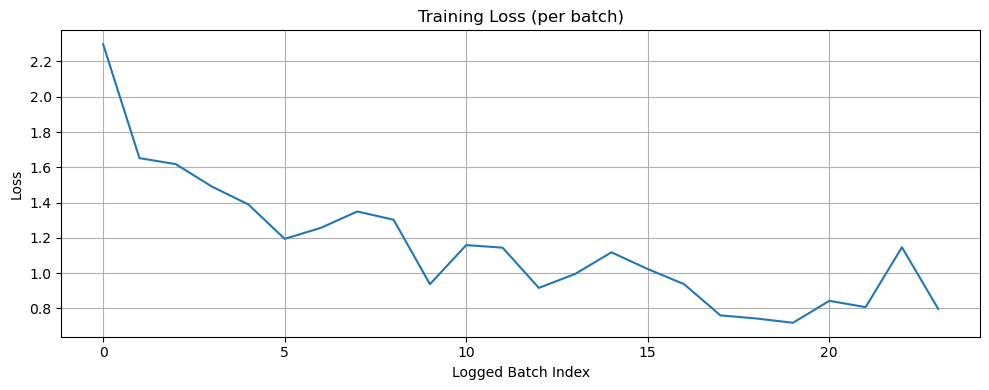

In [355]:
plot_batch_metric(logs_relu, 'loss', title="Training Loss (per batch)", ylabel="Loss")

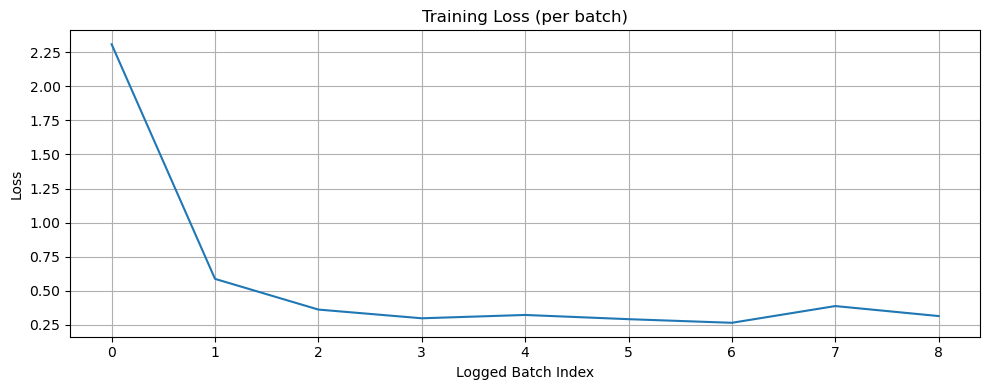

In [307]:
plot_batch_metric(logs_gmodrelu, 'loss', title="Training Loss (per batch)", ylabel="Loss")

In [405]:
logs_relu['batches'][0]

{'epoch': 0,
 'batch_idx': 0,
 'loss': 2.297710418701172,
 'acc': 0.078125,
 'grad_norm': 0.27902655046283154,
 'weight_update_norm': 0.00027902647266799316,
 'samples_seen': 64}

In [593]:
logs_gmodrelus[0].keys()

dict_keys(['batches', 'train_loss', 'train_acc', 'train_grad_norm', 'train_weight_update_norm', 'val_loss', 'val_acc'])

In [462]:
logs_gmodrelus[0]['batches'][0].keys()

dict_keys(['epoch', 'batch_idx', 'loss', 'acc', 'grad_norm', 'weight_update_norm', 'samples_seen'])

In [651]:
def log_data_with_l(l):
    keys = []
    for entry in log_data:
        if entry[0] == 'gmodrelu' and entry[1] == l:
            keys.append(entry)
    keys.sort(key = lambda e: e[2])
    logs = [log_data[e] for e in keys]
    logs_flat = []
    keys_flat = []
    for i, logs in enumerate(logs):
        logs_flat += logs
        keys_flat += [keys[i]]*len(logs)
    return logs_flat, np.array([e[2] for e in keys_flat])

def log_data_with_activation(act):
    keys = []
    for entry in log_data:
        if entry == act:
            keys.append(entry)
    logs = [log_data[e] for e in keys]
    logs_flat = []
    keys_flat = []
    for i, logs in enumerate(logs):
        logs_flat += logs
        keys_flat += [keys[i]]*len(logs)
    return logs_flat, keys_flat

In [883]:
def plot_logs_k(logs, keys,prop = "loss",x_axis = "epoch", file_name = None,i_cut = 1000):
    cmap = mpl.cm.cool
    norm = mpl.colors.PowerNorm(0.11,vmin=keys.min(), vmax=keys.max())
    smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # gmodrelu_loss = extract_batch_metric(logs_gmodrelu, "loss")
    fig, ax = plt.subplots(figsize=(8, 5))
    for i, log in enumerate(logs):
        if i < i_cut:
            if x_axis == "epoch":
                loss = np.array(log[prop])
            else:
                loss = extract_batch_metric(log, prop)
            # plt.plot(loss, color = mpl.cm.cool(i*0.2))
            ax.plot(loss, label = f"k = {keys[i]}",color = smap.to_rgba(keys[i]))
           
            # plt.plot(loss.numpy(), color = mpl.cm.cool(i*0.2))
        
    plt.title(f"CIFAR 10 Loss across {x_axis} (l = 0.02)")
    plt.xlabel(f"{x_axis}")
    plt.ylabel(prop)
    plt.grid(True)
    
    
    cbar = fig.colorbar(smap, ax=ax, orientation='vertical', label='k')
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name)
    

In [960]:
def extract_metric(log,prop,x_axis):
    if x_axis == "epoch":
        loss = np.array(log[prop])
    else:
        loss = extract_batch_metric(log, prop)
    return loss

def plot_logs_ke(logs, keys,prop = "loss",x_axis = "epoch",index = 9, file_name = None,i_cut = 1000, baselines = []):
    cmap = mpl.cm.cool
    norm = mpl.colors.PowerNorm(1,vmin=keys.min(), vmax=keys.max())
    smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # gmodrelu_loss = extract_batch_metric(logs_gmodrelu, "loss")
    fig, axs = plt.subplots(1,2,figsize=(8, 5),width_ratios = [1,5])
    
    y_data = []
    x_data = []
    for i, log in enumerate(logs):
        if i <i_cut:
            loss = extract_metric(log,prop,x_axis)
            lv = loss[index]
            k = keys[i]
            y_data.append(lv)
            x_data.append(k)        
            # plt.plot(loss, color = smap.to_rgba())
           
            # plt.plot(loss.numpy(), color = mpl.cm.cool(i*0.2))
    axs[1].scatter(x_data,y_data)
    # test_vals = np.exp(np.linspace(math.log(1.e-06),math.log(5.e-03),8))
    # axs[1].scatter(test_vals,np.zeros_like(test_vals))
    axs[1].set_xscale('log')
    # axs[1].set_yscale('log')
    # axs[0].set_yscale('log')
    axs[1].grid(True)
        
    plt.title(f"CIFAR 10 Loss after 10 Epochs of training")
    axs[1].set_xlabel(f"ReLU Modified gradient (l = 0.02, k = _)")
    axs[0].set_ylabel(prop)
    axs[0].grid(True)
    axs[0].scatter(baselines[0],[ extract_metric(log,prop,x_axis)[index] for log in baselines[1]])
    axs[0].set_xmargin(0.7)
    axs[0].set_ylim( axs[1].get_ylim() ) # align axes
    axs[1].set_yticklabels([]) # set ticks to be empty (no ticks, no tick-labels)
    
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name)
    plt.show()

In [893]:
math.exp(math.log(2.0))

2.0

In [850]:
logs, keys = log_data_with_l(0.02)
keys

array([0.e+00, 0.e+00, 5.e-05, 1.e-04, 3.e-04, 1.e-03, 3.e-03, 3.e-02,
       3.e-01, 3.e+00])

In [903]:
len(log_data['gelu'])

3

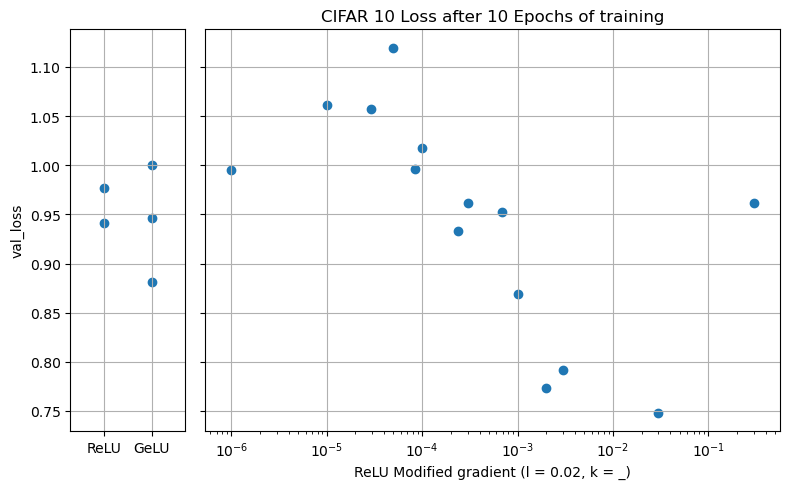

In [994]:
plot_logs_ke(*log_data_with_l(0.02), file_name = "cifar_train_loss_full",prop = "val_loss", x_axis = 'epoch',  i_cut = 16,
             baselines=[["ReLU","ReLU","GeLU","GeLU","GeLU"],[*log_data[('gmodrelu', 0.02, 0.0)],*log_data['gelu']]])
# baselines=[["ReLU","ReLU","GeLU","GeLU","GeLU"],[*log_data[('gmodrelu', 0.02, 0.0)],*log_data['gelu']]

In [626]:
logs,keys = log_data_with_l(0.02)
logs[0].

dict_keys(['batches', 'train_loss', 'train_acc', 'train_grad_norm', 'train_weight_update_norm', 'val_loss', 'val_acc', 'trainloss', 0, 'loss'])

In [667]:
log_data.keys()

dict_keys([('gmodrelu', 0.02, 0.0), ('gmodrelu', 0.02, 0.0003), ('gmodrelu', 0.02, 0.003), ('gmodrelu', 0.02, 0.03), ('gmodrelu', 0.02, 0.3), ('gmodrelu', 0.02, 3.0), ('gmodrelu', 0.02, 5e-05), ('gmodrelu', 0.02, 0.0001), ('gmodrelu', 0.02, 0.001), 'gelu'])

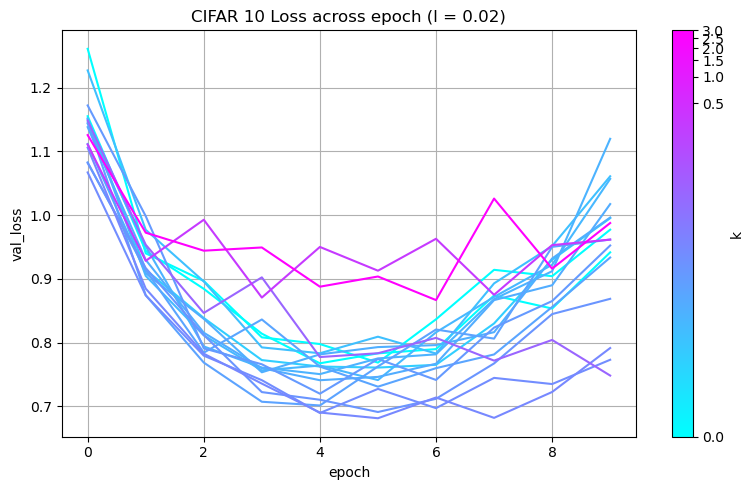

In [983]:
prop = "val_loss"
plot_logs_k(*log_data_with_l(0.02), file_name = None,prop = prop, x_axis = 'epoch',i_cut = 20)
# for log in log_data['gelu']:
#     loss = np.array(log[prop])
#     # loss = extract_batch_metric(log, "train_loss")
#     plt.plot(loss, color = "red")
    

In [368]:
import pickle

In [950]:
# Open a file and use dump() 
with open('log_data.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(log_data, file) 

In [371]:
logs_gmodrelus_1 = logs_gmodrelus

In [380]:
with open('cifar_logs.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    test = pickle.load(file) 

In [385]:
l_vals_1 = test["l_vals"]
l_vals_1

array([0.        , 0.03333333, 0.06666667])